In [1]:
#import sys 
import torch
from torch import optim, save
from torchvision import datasets, transforms
from torchvision.utils import save_image
#from pprint import pprint 

import lipmip.utilities as utils
from lipmip.relu_nets import ReLUNet
#import lipmip.neural_nets.data_loaders as data_loaders
#import lipmip.neural_nets.train as train 
from lipmip.hyperbox import Hyperbox 
import lipmip.interval_analysis as ia 
from lipmip.lipMIP import LipMIP

In [2]:
from models.betavae import loss_function as vae_loss_fn
from models.betavae import SmallVAE, BigVAE
from models.gen import AdversaryModelGen

# Set up dataloader

In [3]:
bs = 200

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

# Train a VAE to learn a smooth embedding function

In [4]:
# load and train BigVAE
# nc = 1
# nz = 8
# ndf = 16
# ngf = 16
beta = 1
# hparams_vae = {"nc": nc, "nz": nz, "ndf": ndf, "ngf": ngf}
# vae = BigVAE(hparams_vae)
# vae.cuda()

# Load and train SmallVAE
vae = SmallVAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=8)
vae.cuda()

SmallVAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=8, bias=True)
  (fc32): Linear(in_features=256, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [4]:
optimizer = optim.Adam(vae.parameters())

# Train the VAE

In [6]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss, _, _ = vae_loss_fn(recon_batch, data, mu, log_var, beta)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [7]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            vae_l, _, _ = vae_loss_fn(recon, data, mu, log_var, beta)
            test_loss += vae_l.item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
for epoch in range(1, 51):
    train(epoch)
    test()

/u/abhi24/matlaberp2/posthoc_privacy/.projenv/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/u/abhi24/matlaberp2/posthoc_privacy/.projenv/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.911283
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.255737
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.240572
====> Epoch: 1 Average loss: 0.2517
====> Test set loss: 0.1969
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.203336
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.178885
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.179962
====> Epoch: 2 Average loss: 0.1814
====> Test set loss: 0.1693
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.168343
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.163051
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.163759
====> Epoch: 3 Average loss: 0.1661
====> Test set loss: 0.1616
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.169925
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.156033
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.153282
====> Epoch: 4 Average loss: 0.1598
====> Test set loss: 0.1573
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.160446
Train Epoch: 5 [20000/60000 (33%)]	Loss: 0.157822
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.161698
====> Epoch: 5 Aver

# Visually verify that all looks good

In [6]:
with torch.no_grad():
    z = torch.randn(64, 8).cuda()
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), './samples/mnist_sample_' + '.png')

/u/abhi24/matlaberp2/posthoc_privacy/.projenv/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Save the VAE model

In [13]:
torch.save(vae.state_dict(), "saved_models/vae.pt")

## Load the VAE model if saved

In [5]:
vae.load_state_dict(torch.load("saved_models/vae.pt"))

<All keys matched successfully>

# Part-2: Jointly train the obfuscator, prediction model, and reconstruction model

## First initialize the three models

In [124]:
obf_out_size = 5
obf_layer_sizes = [8, 10, 10, 6, obf_out_size]
obfuscator = ReLUNet(obf_layer_sizes).cuda()

pred_layer_sizes = [obf_out_size, 10, 10]
pred_model = ReLUNet(pred_layer_sizes).cuda()

adv_model_params = {"channels": obf_out_size, "output_channels": 1, "downsampling": 0, "offset": 4}
adv_model = AdversaryModelGen(adv_model_params).cuda()

In [125]:
pred_loss_fn = torch.nn.CrossEntropyLoss()
rec_loss_fn = torch.nn.MSELoss()

In [126]:
obf_optimizer = optim.Adam(obfuscator.parameters())
pred_optimizer = optim.Adam(pred_model.parameters())
adv_optimizer = optim.Adam(adv_model.parameters())

In [127]:
def train(epoch):
    vae.eval()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):

        data, labels = data.cuda(), labels.cuda()
        # get sample embedding from the VAE
        with torch.no_grad():
            mu, log_var = vae.encoder(data.view(-1, 784))
            z = vae.sampling(mu, log_var)
        
        # pass it through obfuscator
        z_tilde = obfuscator(z)
        # pass obfuscated z through pred_model
        preds = pred_model(z_tilde)
        
        # train obfuscator and pred_model
        pred_loss = pred_loss_fn(preds, labels)
        pred_optimizer.zero_grad()
        obf_optimizer.zero_grad()
        pred_loss.backward(retain_graph=True)
        pred_optimizer.step()
        obf_optimizer.step()

        # pass obfuscated z to adv_model
        rec = adv_model(z_tilde.detach())
        rec_loss = rec_loss_fn(rec, data)
        adv_optimizer.zero_grad()
        rec_loss.backward(retain_graph=True)
        adv_optimizer.step()
        
        # maximizing reconstruction loss by obfuscator
        z_tilde = obfuscator(z)
        rec = adv_model(z_tilde)
        rec_loss = rec_loss_fn(rec, data)
        obf_optimizer.zero_grad()
        (-100*rec_loss).backward()
        obf_optimizer.step()

        loss = pred_loss + rec_loss
        
        train_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, pred_loss {:.3f}, rec_loss {:.3f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data), pred_loss.item(), rec_loss.item()))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [128]:
def test():
    vae.eval()
    test_pred_loss= 0
    test_rec_loss= 0
    pred_correct = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.cuda(), labels.cuda()
            # get sample embedding from the VAE
            mu, log_var = vae.encoder(data.view(-1, 784))
            z = vae.sampling(mu, log_var)

            # pass it through obfuscator
            z_tilde = obfuscator(z)
            # pass obfuscated z through pred_model
            preds = pred_model(z_tilde)
            pred_correct += (preds.argmax(dim=1) == labels).sum()

            # train obfuscator and pred_model
            pred_loss = pred_loss_fn(preds, labels)

            # pass obfuscated z to adv_model
            rec = adv_model(z_tilde)
            rec_loss = rec_loss_fn(rec, data)

            test_pred_loss += pred_loss.item()
            test_rec_loss += rec_loss.item()
        
    test_pred_loss /= len(test_loader.dataset)
    test_rec_loss /= len(test_loader.dataset)
    pred_acc = pred_correct.item() / len(test_loader.dataset)
    print('====> Test pred loss: {:.4f}, rec loss {:.4f}, acc {:.2f}'.format(test_pred_loss, test_rec_loss, pred_acc))

In [129]:
test()

====> Test pred loss: 0.0116, rec loss 0.0012, acc 0.10


In [130]:
for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.012570, pred_loss 2.343, rec_loss 0.171
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.011803, pred_loss 2.295, rec_loss 0.066
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.011846, pred_loss 2.300, rec_loss 0.069
====> Epoch: 1 Average loss: 0.0119
====> Test pred loss: 0.0115, rec loss 0.0003, acc 0.11
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.011856, pred_loss 2.303, rec_loss 0.068
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.011817, pred_loss 2.298, rec_loss 0.066
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.011863, pred_loss 2.306, rec_loss 0.066
====> Epoch: 2 Average loss: 0.0118
====> Test pred loss: 0.0115, rec loss 0.0003, acc 0.11
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.011841, pred_loss 2.298, rec_loss 0.070
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.011828, pred_loss 2.300, rec_loss 0.066
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.011817, pred_loss 2.296, rec_loss 0.067
====> Epoch: 3 Average loss: 0.0118
====> Test pred loss: 0.0115, rec loss 0.0003, a

KeyboardInterrupt: 

## Visual verification

In [131]:
import matplotlib.pyplot as plt

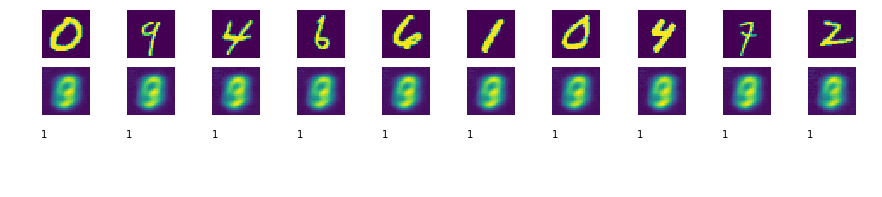

In [132]:
_, ax = plt.subplots(nrows=3,ncols=10,figsize=(15,3))

data, labels = next(iter(train_loader))
data, labels = data.cuda(), labels.cuda()
# get sample embedding from the VAE
with torch.no_grad():
    mu, log_var = vae.encoder(data.view(-1, 784))
    z = mu#vae.sampling(mu, log_var)
    z_tilde = obfuscator(z)
    rec = adv_model(z_tilde)
    preds = pred_model(z_tilde).argmax(dim=1)

for i in range(10):
    ax[0][i].imshow(data[i][0].detach().cpu())
    ax[0][i].axis("off")
    ax[1][i].imshow(rec[i][0].detach().cpu())
    ax[1][i].axis("off")
    ax[2][i].text(0.2, 0.8, str(preds[i].item()), horizontalalignment='center', verticalalignment='center')#, transform=ax1.transAxes)
    ax[2][i].axis("off")

# Inference Privacy
## Freeze the privacy parameter $\Delta_{LS}^{p}$ and the required radius $s$
## Get the embedding of the target sample
## Use it as a center
## Find the best possible radius

In [133]:
data, labels = next(iter(train_loader))
data, labels = data.cuda(), labels.cuda()
# get sample embedding from the VAE
with torch.no_grad():
    mu, log_var = vae.encoder(data.view(-1, 784))
    z = mu#vae.sampling(mu, log_var)


In [134]:
obfuscator.cuda()(z).min()

tensor(-0.5102, device='cuda:0', grad_fn=<MinBackward1>)

In [146]:
epsilon = 5
delta = 0.1

center = z#torch.rand(10)
radius = 1.0
simple_domain = Hyperbox.build_linf_ball(center, radius)

# For now we are using center of 0 and l_inf norm of size 1 around the center to define the output space
output_domain = 'l1Ball1'

# TODO: Replace it with a trained NN
#network_simple = ReLUNet([8, 7, 5, 5])
network_simple = obfuscator.cpu()

In [147]:
cross_problem = LipMIP(network_simple, simple_domain, 'l1Ball1', num_threads=8, verbose=True)
cross_problem.compute_max_lipschitz()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1600 and 8x10)

In [145]:
cross_problem.result.value

0.4097048069197993